# 随机森林（Random Forest）

【关键词】量化金融；网格搜索；收益回测

## 1. 基础框架

In [112]:
# 随机森林分类模型
from sklearn.ensemble import RandomForestClassifier
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [0, 0, 0, 1, 1]

model = RandomForestClassifier(n_estimators=10, random_state=1)
model.fit(X, y)

print(model.predict([[5, 5]]))

[0]


In [113]:
# 随机森林回归模型
from sklearn.ensemble import RandomForestRegressor
X = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
y = [1, 2, 3, 4, 5]

model = RandomForestRegressor(n_estimators=10, random_state=1)
model.fit(X, y)

print(model.predict([[5, 5]]))

[2.6]


## 2. 案例：量化金融：股票涨跌预测多因子模型

**1. 引入之后需要用到的库**   
【注】Windows64位系统，直接使用pip install talib语句会报错，原因在于python pip源中TA-Lib是32位的，不能安装在64位系统平台上。
正确的方法是下载64位的安装包后本地安装，下载推荐使用加州大学的python扩展库，地址：https://www.lfd.uci.edu/~gohlke/pythonlibs/

In [ ]:
import tushare as ts  # 股票基本数据相关库
import numpy as np  # 科学计算相关库
import pandas as pd  # 科学计算相关库  
import talib  # 股票衍生变量数据相关库
import matplotlib.pyplot as plt  # 引入绘图相关库
from sklearn.ensemble import RandomForestClassifier  # 引入分类决策树模型
from sklearn.metrics import accuracy_score  # 引入准确度评分函数
import warnings
warnings.filterwarnings("ignore") # 忽略警告信息，警告非报错，不影响代码执行

**2. 股票数据处理与衍生变量生成**  
【注】获取股票数据需要注册并登录tushar官网，得到api的口令后方能获取基础数据。

In [93]:
# 导入tushare
import tushare as ts

# 初始化pro接口
pro = ts.pro_api('xxx') # 此处需填入自己的口令

# 拉取数据
df = pro.daily(**{
    "ts_code": "600519.SH",
    "trade_date": "",
    "start_date": "2013-01-01",
    "end_date": "",
    "offset": "",
    "limit": ""
}, fields=[
    "ts_code",
    "trade_date",
    "open",
    "high",
    "low",
    "close",
    "pre_close",
    "change",
    "pct_chg",
    "vol",
    "amount"
])

# 显示数据
df
        

,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,600519.SH,20230131,1896.50,1899.95,1833.07,1845.76,1888.00,-42.24,-2.2373,32990.68,6128311.548
1,600519.SH,20230130,1909.00,1909.00,1880.00,1888.00,1860.01,27.99,1.5048,35922.55,6799756.571
2,600519.SH,20230120,1889.19,1898.25,1858.00,1860.01,1880.21,-20.20,-1.0743,25608.75,4807356.071
3,600519.SH,20230119,1892.50,1892.52,1866.00,1880.21,1893.00,-12.79,-0.6756,23438.89,4401994.437
4,600519.SH,20230118,1914.00,1925.30,1890.00,1893.00,1908.00,-15.00,-0.7862,21062.93,4008665.438
...,...,...,...,...,...,...,...,...,...,...,...
2441,600519.SH,20130110,215.58,217.00,213.00,214.50,216.45,-1.95,-0.9000,30527.86,656830.931
2442,600519.SH,20130109,211.50,217.65,211.50,216.45,210.84,5.61,2.6600,53749.32,1159330.305
2443,600519.SH,20130108,203.18,210.85,203.18,210.84,204.29,6.55,3.2100,65286.98,1362186.171
2444,600519.SH,20130107,205.88,205.88,202.50,204.29,206.94,-2.65,-1.2800,41271.39,840359.829


In [94]:
# 原始数据按时间的降序排列，需改变排列顺序
df.sort_values('trade_date',ascending=True,inplace=True)
df = df.set_index('trade_date')
df

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
20130104,600519.SH,212.00,212.00,205.00,206.94,209.02,-2.08,-1.0000,58370.34,1205796.538
20130107,600519.SH,205.88,205.88,202.50,204.29,206.94,-2.65,-1.2800,41271.39,840359.829
20130108,600519.SH,203.18,210.85,203.18,210.84,204.29,6.55,3.2100,65286.98,1362186.171
20130109,600519.SH,211.50,217.65,211.50,216.45,210.84,5.61,2.6600,53749.32,1159330.305
20130110,600519.SH,215.58,217.00,213.00,214.50,216.45,-1.95,-0.9000,30527.86,656830.931
...,...,...,...,...,...,...,...,...,...,...
20230118,600519.SH,1914.00,1925.30,1890.00,1893.00,1908.00,-15.00,-0.7862,21062.93,4008665.438
20230119,600519.SH,1892.50,1892.52,1866.00,1880.21,1893.00,-12.79,-0.6756,23438.89,4401994.437
20230120,600519.SH,1889.19,1898.25,1858.00,1860.01,1880.21,-20.20,-1.0743,25608.75,4807356.071


变量解释：  
trade_date:交易日期, ts_code:股票代码,   
open:开盘价, high:最高价, low:最低价, close:收盘价,   
pre_close:昨收价, change:涨跌额, pct_chg:涨跌幅, vol:成交量, amount:成交额

In [95]:
# 简单衍生变量构造
df['close-open'] = (df['close'] - df['open'])/df['open']
df['high-low'] = (df['high'] - df['low'])/df['low']

# 移动平均线相关数据构造
df['MA5'] = df['close'].rolling(5).mean()
df['MA10'] = df['close'].rolling(10).mean()
df.dropna(inplace=True)  # 删除空值

# 通过Ta_lib库构造衍生变量
df['RSI'] = talib.RSI(df['close'], timeperiod=12)  # 相对强弱指标
df['MOM'] = talib.MOM(df['close'], timeperiod=5)  # 动量指标
df['EMA12'] = talib.EMA(df['close'], timeperiod=12)  # 12日指数移动平均线
df['EMA26'] = talib.EMA(df['close'], timeperiod=26)  # 26日指数移动平均线
df['MACD'], df['MACDsignal'], df['MACDhist'] = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)  # MACD值
df.dropna(inplace=True)  # 删除空值

df

,ts_code,open,high,low,close,pre_close,change,pct_chg,vol,amount,...,high-low,MA5,MA10,RSI,MOM,EMA12,EMA26,MACD,MACDsignal,MACDhist
trade_date,,,,,,,,,,,,,,,,,,,,,
20130312,600519.SH,186.00,186.10,180.00,182.18,185.20,-3.02,-1.6300,25393.65,465220.571,...,0.033889,182.518,178.790,47.066005,7.18,180.772429,182.823942,-1.961282,-3.694324,1.733042
20130313,600519.SH,182.40,186.02,182.40,183.83,182.18,1.65,0.9100,30769.90,567812.074,...,0.019846,183.840,179.496,50.016872,6.61,181.242825,182.898465,-1.579291,-3.271317,1.692026
20130314,600519.SH,182.50,184.77,178.66,178.94,183.83,-4.89,-2.6600,35124.00,635985.859,...,0.034199,182.856,179.890,42.378900,-4.92,180.888544,182.605245,-1.652098,-2.947473,1.295375
20130315,600519.SH,177.52,180.70,175.10,176.97,178.94,-1.97,-1.1000,35961.12,639236.967,...,0.031982,181.424,180.205,39.713596,-7.16,180.285691,182.187819,-1.847464,-2.727472,0.880007
20130318,600519.SH,176.90,176.90,168.19,169.45,176.97,-7.52,-4.2500,78231.53,1336285.511,...,0.051787,178.274,179.678,31.471245,-15.75,178.618662,181.244277,-2.579362,-2.697850,0.118488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230118,600519.SH,1914.00,1925.30,1890.00,1893.00,1908.00,-15.00,-0.7862,21062.93,4008665.438,...,0.018677,1886.980,1858.027,70.869131,48.05,1846.918032,1791.762041,55.155991,46.961091,8.194900
20230119,600519.SH,1892.50,1892.52,1866.00,1880.21,1893.00,-12.79,-0.6756,23438.89,4401994.437,...,0.014212,1896.222,1865.948,66.952438,46.21,1852.039873,1798.313742,53.726131,48.314099,5.412033
20230120,600519.SH,1889.19,1898.25,1858.00,1860.01,1880.21,-20.20,-1.0743,25608.75,4807356.071,...,0.021663,1890.824,1871.572,61.131453,-26.99,1853.266046,1802.883835,50.382211,48.727721,1.654490


**3. 特征变量和目标变量提取**

In [96]:
X = df[['close', 'vol', 'close-open', 'MA5', 'MA10', 'high-low', 'RSI', 'MOM', 'EMA12', 'MACD', 'MACDsignal', 'MACDhist']]
y = np.where(df['change'].shift(-1)> 0, 1, -1)

np.where(判断条件,满足条件的赋值,不满足条件的赋值)

df['price_change'].shift(-1)则是利用shift()函数将price_change（股价变化）这一列往上移动一行，由此获得每一行对应的下一天股价涨跌情况。  

若下一天股价涨了则将y赋值为1，股价跌了赋值为-1。

**4. 训练集和测试集数据划分**

In [97]:
X_length = X.shape[0]  # shape属性获取X的行数和列数，shape[0]即表示行数 
split = int(X_length * 0.9) # 将数据集进行9：1划分

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

**5. 模型搭建**

In [98]:
model = RandomForestClassifier(max_depth=3, n_estimators=10, min_samples_leaf=10, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=10, n_estimators=10,
                       random_state=1)

**6. 模型使用与评估**

In [102]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(X_test)
score = accuracy_score(y_pred, y_test)
print(score)

0.4896265560165975


In [103]:
# 此外，还可以通过模型自带的score()函数记性打分
model.score(X_test, y_test)

0.4896265560165975

**7. 分析数据特征的重要性**

In [104]:
model.feature_importances_

array([0.07744398, 0.12096661, 0.21470336, 0.09718213, 0.05067005,
       0.10560949, 0.07092666, 0.0660732 , 0.06698151, 0.07279595,
       0.0388816 , 0.01776546])

In [105]:
# 通展示特征及其特征重要性：
features = X.columns  
importances = model.feature_importances_
f = pd.DataFrame()
f['特征'] = features
f['特征重要性'] = importances
f = f.sort_values('特征重要性', ascending=False)
f

,特征,特征重要性
2,close-open,0.214703
1,vol,0.120967
5,high-low,0.105609
3,MA5,0.097182
0,close,0.077444
9,MACD,0.072796
6,RSI,0.070927
8,EMA12,0.066982
7,MOM,0.066073
4,MA10,0.050670


**8. 网格搜索参数调优**

In [106]:
from sklearn.model_selection import GridSearchCV  # 网格搜索合适的超参数
# 指定分类器中参数的范围
parameters = {'n_estimators':[5, 10, 20], 'max_depth':[2, 3, 4, 5], 'min_samples_leaf':[5, 10, 20, 30]}
new_model = RandomForestClassifier(random_state=1)  # 构建分类器
grid_search = GridSearchCV(new_model, parameters, cv=6, scoring='accuracy') 

In [107]:
grid_search.fit(X_train, y_train)  # 传入数据
grid_search.best_params_  # 输出参数的最优值

{'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 10}

In [108]:
# 以最优参数进行模型预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_pred, y_test)
acc

0.5269709543568465

**9. 收益回测曲线绘制**

In [109]:
X_test['prediction'] = best_model.predict(X_test)
X_test['p_change'] = (X_test['close'] - X_test['close'].shift(1)) / X_test['close'].shift(1)

X_test['origin'] = (X_test['p_change'] + 1).cumprod()
X_test['strategy'] = (X_test['prediction'].shift(1) * X_test['p_change'] + 1).cumprod()

X_test[['strategy', 'origin']].tail()

,strategy,origin
trade_date,,
20230118,0.939034,0.963359
20230119,0.932689,0.956850
20230120,0.922669,0.946570
20230130,0.936553,0.960814
20230131,0.915600,0.939318


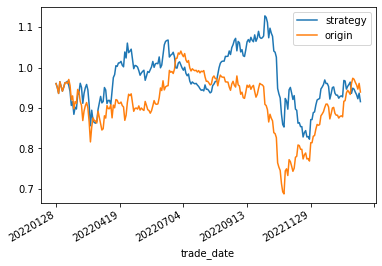

In [111]:
# 收益可视化
X_test[['strategy', 'origin']].dropna().plot()
plt.gcf().autofmt_xdate() # 设置X轴刻度自动倾斜
plt.show()